Semantic Information in a Simple Food-Seeking Agent
====

In [43]:
from __future__ import print_function
import numpy as np
import utils

# Define parameters of model
mode            = 'pos'   # 'pos' if the system should move towards food, 'neg' if it should move away from food

timescale       = 5       # \tau, the timescale of interest

num_locations   = 5       # Number of food locations
num_levels      = 5       # l_max -- maximum food level 
eat_radius      = 1       # How close the agent must approach the food before it can eat it
food_disappear_rate = 0.1 # The rate at which food spontaneously disappears
dead_entropy    = 100      # Internal entropy of the dead macrostate (when agent level = 0), in bits

# The viability function
def agent_negentropy(curp):
    # curp is distribution over joint states
    pX, _ = utils.get_marginals(curp, id2xy_id_dict)
    deadprob = 0.
    for ndx, p in enumerate(curp):
        if id2state_dict[ndx][2] == 0:
            deadprob += p
    h = utils.entropy(pX, base=2) + deadprob*dead_entropy
    return -h

In [44]:
# Here we define parameters / free energy function that will determine system/environment dynamics

agentlevel_fe  = 10                         # Free energy increase for each agent level
food_fe        = num_levels*2*agentlevel_fe # Free energy in one unit of food
dead_fe        = -np.log(2) * dead_entropy  # Free energy of death state (bits to nats)

# Compute free energy of joint system/environment state
def free_energy_joint(agentloc, agenttarget, agentlevel, foodloc):
    r = agentlevel_fe * agentlevel
    if agentlevel == 0   : r += dead_fe
    if foodloc    != '-' : r += food_fe
    return r

In [45]:
# Here we define state space of joint system

state2id_dict  = {}       # Dictionary maps joint state tuples (agentloc, agenttarget, agentlevel, foodloc) to numeric id
Xstate2id_dict = {}       # Dictionary maps X state tuples (agentloc, agenttarget, agentlevel) to numeric id
Ystate2id_dict = {}       # Dictionary maps Y state foodloc to numeric id
id2xy_id_dict  = {}       # Dictionary that maps joint state numeric idea to tuple ()

# Setup state space dictionaries 
for agentloc in range(num_locations):
    for agenttarget in list(range(num_locations)) + ['-']:
        for agentlevel in range(num_levels):
            for foodloc in list(range(num_locations)) + ['-']:
                K = (agentloc, agenttarget, agentlevel, foodloc)
                xK = (agentloc, agenttarget, agentlevel)
                yK = foodloc
                state2id_dict.setdefault(K, len(state2id_dict))
                Xstate2id_dict.setdefault(xK, len(Xstate2id_dict))
                Ystate2id_dict.setdefault(yK, len(Ystate2id_dict))
                id2xy_id_dict[state2id_dict[K]] = (Xstate2id_dict[xK], Ystate2id_dict[yK])
                
# Dictionary that maps from numeric id to 
id2state_dict = utils.reverse_dict(state2id_dict)

num_states = len(state2id_dict)

In [46]:
# Create the dynamics, i.e., the stochastic transition matrix, m

mxbase = np.zeros((num_states, num_states))

def get_food_states(agentloc, agenttarget, agentlevel, foodloc):
    if foodloc == '-':
        return [((agentloc, agenttarget, agentlevel, foodloc),1),]
    else:
        return [((agentloc, agenttarget, agentlevel, foodloc), 1-food_disappear_rate),
                ((agentloc, agenttarget, agentlevel, '-'), food_disappear_rate)
               ]
for jointstate, i in state2id_dict.items():
    agentloc, agenttarget, agentlevel, foodloc = jointstate
    is_dead     = agentlevel==0
    eat_food    = np.abs(agentloc - foodloc) <= eat_radius if foodloc != '-' else False
    food_avail  = foodloc != '-'
    next_states = []
    
    base_update = get_food_states(agentloc, agenttarget, agentlevel-1, foodloc)
    if not is_dead:
        if eat_food:
            next_states = [((agentloc,'-',num_levels - 1,'-'), 1),]
        elif agenttarget == '-':
            next_states = base_update
        else:
            if mode == 'pos':
                direction_mult = 1.0
            elif mode == 'neg':
                direction_mult = -1.0
            elif mode == 'neutral':
                direction_mult = 0.0
            else:
                raise Exception()
                
            if agenttarget>agentloc:
                next_loc = agentloc+direction_mult*1
            elif agenttarget<agentloc:
                next_loc = agentloc-direction_mult*1
            else:
                next_loc = agentloc
                
            if next_loc < 0:
                next_loc = 0
            elif next_loc > num_locations-1:
                next_loc = num_locations-1
                
            next_states = get_food_states(next_loc, agenttarget, agentlevel-1, foodloc)
            
    else: 
        next_states = get_food_states(agentloc, agenttarget, agentlevel, foodloc)

    for n, p in next_states:
        ns = state2id_dict[n]
        mxbase[i, ns] = p
        # The following enforces LDB is obeyed for transitions between states. 
        mxbase[ns, i] = p*np.exp(-(free_energy_joint(*jointstate)-free_energy_joint(*n)))

# Normalize the constructed matrix to be a valid transition matrix
mx = utils.normalize_mx(mxbase)

# Compute the transition matrix from t=0 to t=timescale
timeevolvedmx = np.linalg.matrix_power(mx, timescale)

In [47]:
# Define the initial distribution over joint states
initp = np.zeros(num_states)
agentinitloc = int(num_locations/2)
# Uniform distribution over food locations
for j in range(num_locations):
    initp[state2id_dict[agentinitloc, j, num_levels - 1, j]] = 1.0
initp/=initp.sum() # normalize to a valid probability distribution

In [48]:
# Build viability/information curve
interventions = utils.get_all_interventions(num_locations, initp, state2id_dict, id2xy_id_dict)
info_curve = {}
for intervention_ndx, (intervened_initp, cg_func) in enumerate(interventions):
    cur_mi = utils.get_mi(intervened_initp, id2xy_id_dict)
    viability = agent_negentropy(intervened_initp.dot(timeevolvedmx))
    viability, cur_mi = np.round(viability, 5), np.round(cur_mi, 5)
    print('Viability=%0.3f, MI=%0.3f, Coarse-graining function=%s (%d/%d)' % 
          (viability, cur_mi, cg_func, intervention_ndx+1, len(interventions)))
    if (cur_mi not in info_curve) or (viability > info_curve[cur_mi]):
        info_curve[cur_mi] = viability

Viability=-87.633, MI=0.000, Coarse-graining function=[[0, 1, 2, 3, 4, '-']] (1/32)
Viability=-74.785, MI=0.722, Coarse-graining function=[[0], [1, 2, 3, 4, '-']] (2/32)
Viability=-71.709, MI=0.971, Coarse-graining function=[[0, 1], [2, 3, 4, '-']] (3/32)
Viability=-71.709, MI=0.971, Coarse-graining function=[[0, 1, 2], [3, 4, '-']] (4/32)
Viability=-74.785, MI=0.722, Coarse-graining function=[[0, 1, 2, 3], [4, '-']] (5/32)
Viability=-87.633, MI=0.000, Coarse-graining function=[[0, 1, 2, 3, 4], ['-']] (6/32)
Viability=-71.689, MI=1.371, Coarse-graining function=[[0], [1], [2, 3, 4, '-']] (7/32)
Viability=-65.545, MI=1.522, Coarse-graining function=[[0], [1, 2], [3, 4, '-']] (8/32)
Viability=-65.525, MI=1.371, Coarse-graining function=[[0], [1, 2, 3], [4, '-']] (9/32)
Viability=-74.785, MI=0.722, Coarse-graining function=[[0], [1, 2, 3, 4], ['-']] (10/32)
Viability=-65.565, MI=1.522, Coarse-graining function=[[0, 1], [2], [3, 4, '-']] (11/32)
Viability=-65.545, MI=1.522, Coarse-graining

Initial MI                     =   2.32 bits
Amount of semantic information =   1.37 bits
Semantic efficiency            =   0.59
Value of information           =  22.11 bits
Thermodynamic multiplier       =   9.52


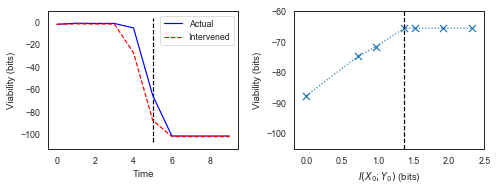

In [49]:
# Plot results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

plt.figure(figsize=(7,2.75))
plt.subplot(1,2,1)

# Define the fully-intervened initial distribution over joint states
pX, pY = utils.get_marginals(initp, id2xy_id_dict)
initp_fullyintervened = np.zeros(num_states)
for ndx in range(num_states):
    x,y = id2xy_id_dict[ndx]
    initp_fullyintervened[ndx] = pX[x]*pY[y]
    
# Show a time vs. viability plot for actual initial distribution and fully intervened initial distribution
l1, l2 = utils.compare_runs(initp, mx, initp_fullyintervened, mx, viabilityfunc=agent_negentropy, iters=10)
plt.ylabel('Viability (bits)')
plt.xlabel('Time')
plt.vlines(timescale, plt.ylim()[0], plt.ylim()[1], linestyle='--')
value_of_information = l1[timescale] - l2[timescale]

plt.subplot(1,2,2)
    
# Take pareto front of viability/information curve
ks = np.array(list(map(lambda x: x[0], sorted(info_curve.items(), key=lambda x: (np.round(x[0],7),x[1])))))
vs = np.array([info_curve[k] for k in ks])

plt.plot(ks, vs, ':')
plt.scatter(ks, vs, s=50, marker='x')

plt.xlabel('$I(X_0;Y_0)$ (bits)')
plt.ylabel('Viability (bits)')

actual_mi = utils.get_mi(initp, id2xy_id_dict)
total_si = np.min(ks[vs == vs[-1]])
print("Initial MI                     = %6.2f bits" % actual_mi)
print("Amount of semantic information = %6.2f bits" % total_si)
print("Semantic efficiency            = %6.2f"      % (total_si/actual_mi))
print("Value of information           = %6.2f bits" % value_of_information)
print("Thermodynamic multiplier       = %6.2f"      % (value_of_information/actual_mi))

plt.ylim([-105,-60])
plt.vlines(total_si, plt.ylim()[0], plt.ylim()[1], linestyle='--')

plt.tight_layout()
